In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import warnings
warnings.filterwarnings("ignore")
import os
from collections import Counter
import seaborn as sns
import scipy as sc
from sklearn.metrics import roc_auc_score
import gc #importing garbage collector
import time
from scipy import signal
%matplotlib inline  

#SEED = 42
#Pandas - Displaying more rorws and columns
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [127]:
import tensorflow as tf
import keras

# Data Introduction& EDA
### So firstly, load in four data sets.
## calendar
### Let's give an general overview on the data set. The calendar.csv contains information about the dates when the products are sold.It contains 1969 records with 14 columns serving as features.For example, the column 'date' is the date in a “y-m-d” format.

In [2]:
calendar = pd.read_csv('calendar.csv')
sell_price = pd.read_csv('sell_prices.csv')
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')

In [3]:
#Let's give an general overview on the data set.
#The calendar.csv contains information about the dates when the products are sold.
# It contains 1969 records with 14 columns serving as features.
#For example, the column 'date' is the date in a “y-m-d” format.
#wm_yr_wk: The id of the week the date belongs to.
#weekday: The type of the day (Saturday, Sunday, …, Friday).
#wday: The id of the weekday, starting from Saturday.
#month: The month of the date.
#year: The year of the date.
#event_name_1: If the date includes an event, the name of this event.
#event_type_1: If the date includes an event, the type of this event.
#event_name_2: If the date includes a second event, the name of this event.
#event_type_2: If the date includes a second event, the type of this event.
#snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
calendar.shape

(1969, 14)

## sell_price
### The sell_price.csv contains  information about the price of the products sold per store and date.For example, the column 'sell_price' represents the price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set). There are 6841121 records.



In [5]:
#store_id: The id of the store where the product is sold.
#item_id: The id of the product.
#wm_yr_wk: The id of the week.
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
sell_price.shape

(6841121, 4)

# Sales train
### The file “sales_train.csv” includes the historical daily unit sales data per product and store. We can know the number of units sold in one store on some specific day starting from Jan 29 in 2011. Here the data set related to sales train has been divided into the evaluation part with the dimesnion (30490,1947) and the validation part with the dimension  (30490,1919).
### For these three tables, the hierarchy relationship is shown as follows.配那个链接里的图也可以自己画。也可以文字描述。The top is given by the unit sales of all products, aggregated for all stores/states. Then，unit sales of all products, aggregated for each state. Unit sales of all products, aggregated for each store and etc.

#### Unit sales of all products, aggregated for each category.
#### Unit sales of all products, aggregated for each department.

In [7]:
#item_id: The id of the product.
#dept_id: The id of the department the product belongs to.
#cat_id: The id of the category the product belongs to.
#store_id: The id of the store where the product is sold.
#state_id: The State where the store is located.
#d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,1,0,2,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,2,3,0,2,0,0,2,2,0,0,2,1,2,1,1,1,2,...,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [8]:
sales_train_evaluation.shape

(30490, 1947)

In [9]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,1,0,2,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,2,3,0,2,0,0,2,2,0,0,2,1,2,1,1,1,2,...,3,2,4,3,1,2,3,0,8,2,1,2,2,5,2,6,1,0,3,5,1,1,6,4,3,2,2,3,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,3,0,0,1,1,0,3,1,0,4,1,2,0,0,0,1,1,2,0,0,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [10]:
sales_train_validation.shape

(30490, 1919)

# Data overview
## From the graph, it has become much clearer how these levels are aggregated by performing groupby and summing up the sales. At the same time, we can already observe nice periodic patterns. So we are asked to generate forecasts for grouped timeseries.The timeseries in training data, belong to the bottom-level 12: Unit sales of product x, aggregated for each store. A simple method to generate forecasts for all levels is to focus only on the bottom level. All of its predictions are then summed up to create the forecasts of all levels up to the top. This is called the bottom-up approach.


In [11]:
series_cols = sales_train_evaluation.columns[sales_train_evaluation.columns.str.contains("d_")].values
level_cols = sales_train_evaluation.columns[sales_train_evaluation.columns.str.contains("d_")==False].values

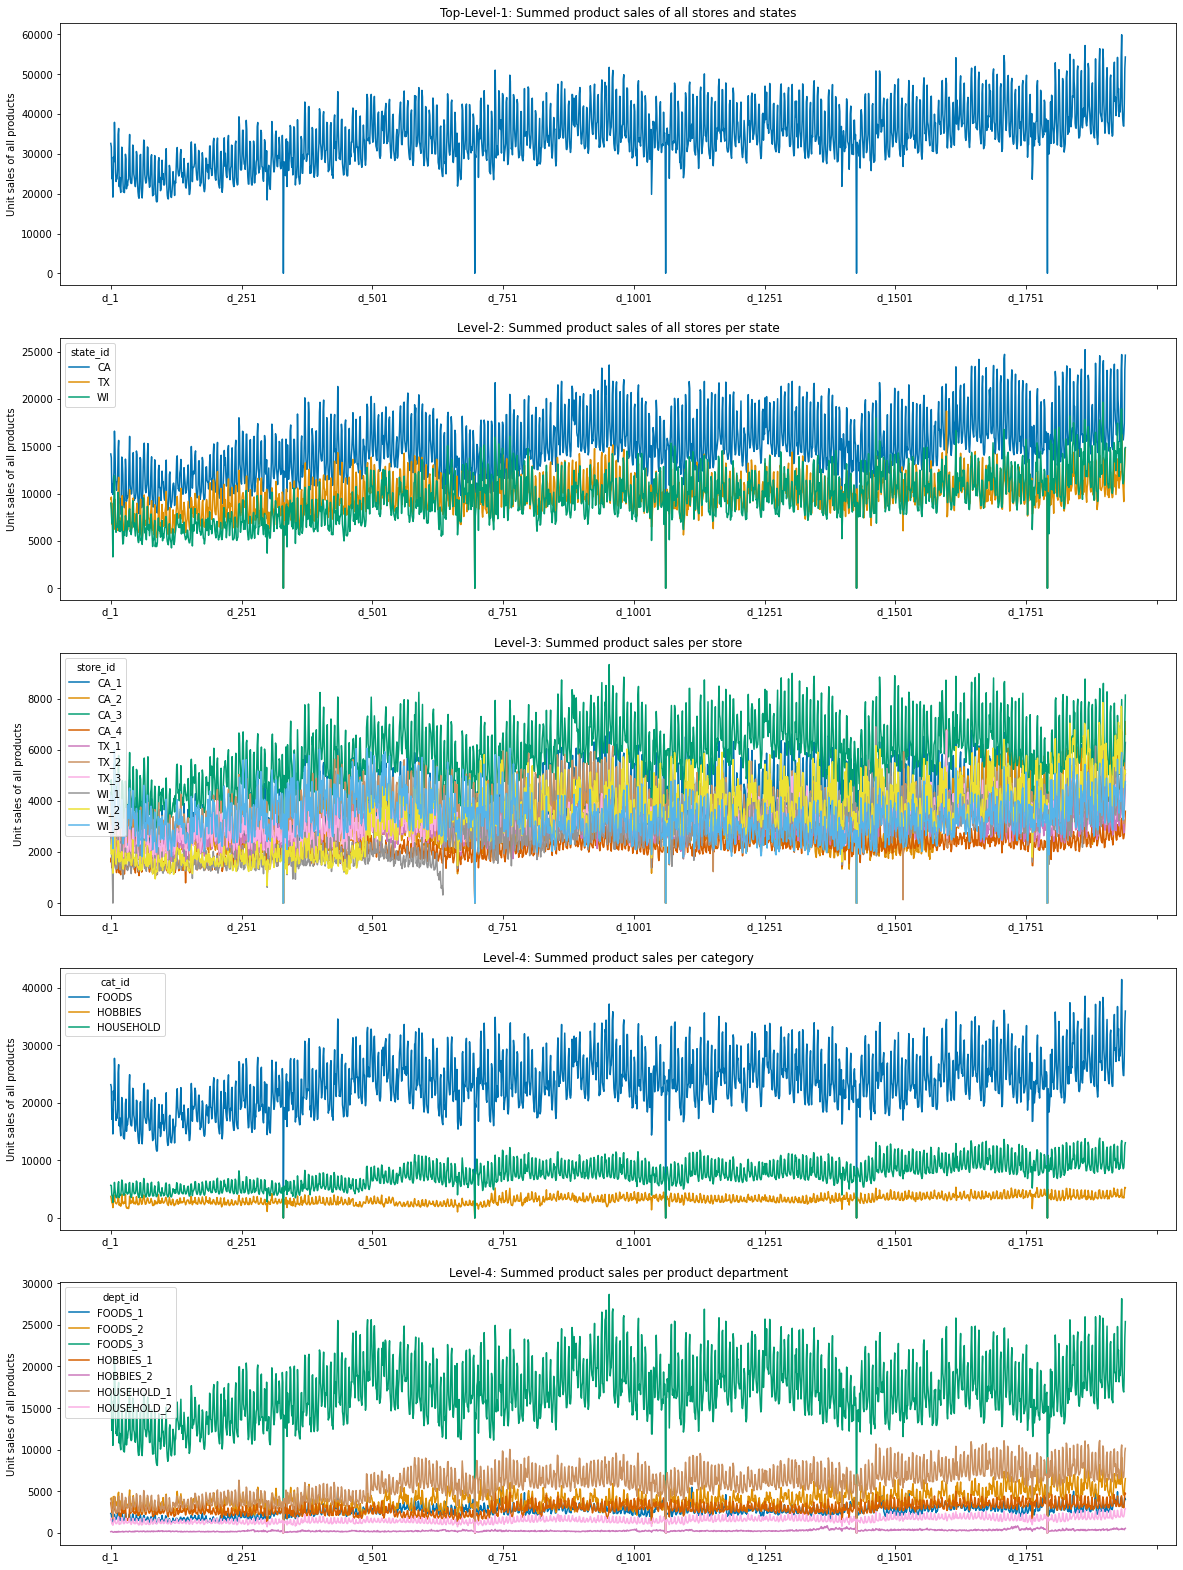

In [12]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
sales_train_evaluation[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
sales_train_evaluation.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
sales_train_evaluation.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
sales_train_evaluation.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
sales_train_evaluation.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

链接里有张表格
## Thus， in this project, we are trying to solve the aggregated time series whose levels are shown as the table.
## Level id	           Aggregation Level	                     Number of series
1	Unit sales of all products, aggregated for all stores/states	  1
2	Unit sales of all products, aggregated for each State	           3
3	Unit sales of all products, aggregated for each store	           10
4	Unit sales of all products, aggregated for each category	       3
5	Unit sales of all products, aggregated for each department	        7
6	Unit sales of all products, aggregated for each State and category	9
7	Unit sales of all products, aggregated for each State and department	21
8	Unit sales of all products, aggregated for each store and category	    30
9	Unit sales of all products, aggregated for each store and department	70
10	Unit sales of product x, aggregated for all stores/states	       3,049
11	Unit sales of product x, aggregated for each State	           9,147
12	Unit sales of product x, aggregated for each store	              30,490
Total	                                                              42,840

# Introduction结束 EDA开始
## EDA for the submission
### Since the dimension of submission sample is (771120,29), we try to figure out the 771120 under the fact that the forecasts are required to provide prediction on intervals and quatiles . Thus we give EDA on the submission sample shown as follows.截彩色6图. It implies that each quartile  has exactily  2∗42840=85680 requests. The total number of all 12 level timeseries is 42840, which is consistent with the table above. Meanwhile, we can infer that 42840*9*2=771120, implying that there are 9 quartiles.


In [13]:
submission=pd.read_csv('sample_submission.csv')
submission.shape

(771120, 29)

In [14]:
def find_quartil(l):
    
    if "0.005" in l:
        return 0.005
    elif "0.025" in l:
        return 0.025
    elif "0.165" in l:
        return 0.165
    elif "0.25" in l:
        return 0.25
    elif "0.5" in l:
        return 0.5
    elif "0.75" in l:
        return 0.75
    elif "0.835" in l:
        return 0.835
    elif "0.975" in l:
        return 0.975
    elif "0.995" in l:
        return 0.995
    else:
        return 0
    
def find_state(l):
    if "CA" in l:
        return "CA"
    elif "TX" in l:
        return "TX"
    elif "WI" in l:
        return "WI"
    else:
        return "Unknown"
    
def find_category(l):
    if "FOODS" in l:
        return "foods"
    elif "HOBBIES" in l:
        return "hobbies"
    elif "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [15]:
submission_eda = pd.DataFrame(submission.id, columns=["id"])
submission_eda.loc[:, "lb_type"] = np.where(submission.id.str.contains("validation"), "validation", "evaluation")
submission_eda.loc[:, "u"] = submission.id.apply(lambda l: find_quartil(l))
submission_eda.loc[:, "state"] = submission.id.apply(lambda l: find_state(l))
submission_eda.loc[:, "category"] = submission.id.apply(lambda l: find_category(l))

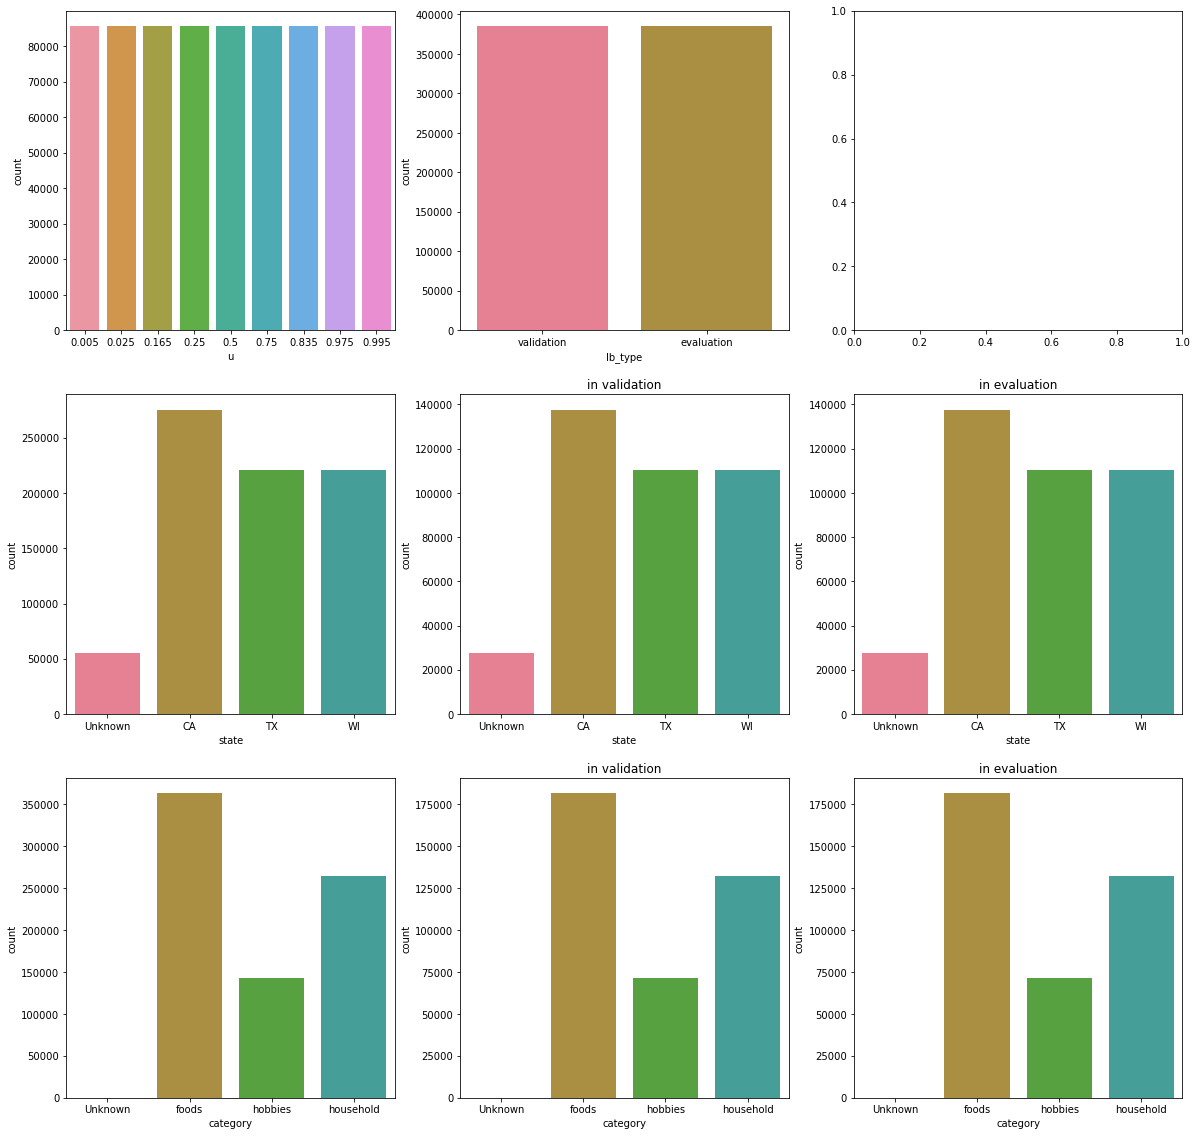

In [16]:
sns.set_palette("husl")

fig, ax = plt.subplots(3,3,figsize=(20,20))
sns.countplot(submission_eda.u, ax=ax[0,0]);
sns.countplot(submission_eda.lb_type, ax=ax[0,1]);
sns.countplot(submission_eda.state, ax=ax[1,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].state, ax=ax[1,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].state, ax=ax[1,2]);
sns.countplot(submission_eda.category, ax=ax[2,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].category, ax=ax[2,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].category, ax=ax[2,2]);
for n in range(1,3):
    ax[n,2].set_title("in evaluation")
    ax[n,1].set_title("in validation")

## EDA for the sale_train
### Firstly, let's check the missing values. The results turn that only 'calendar' contains missing values due to real situations. 带上下面的missing values的表。So, we will check calendar in detail. We guess that we may find something interesting about sales on events.

In [17]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [18]:
missing_values_table(calendar)

Your selected dataframe has 14 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
event_name_2,1964,99.7
event_type_2,1964,99.7
event_name_1,1807,91.8
event_type_1,1807,91.8


In [19]:
missing_values_table(sell_price)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [20]:
missing_values_table(sales_train_evaluation)

Your selected dataframe has 1947 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [21]:
missing_values_table(sales_train_validation)

Your selected dataframe has 1919 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# Calendar EDA（mainly outlier）
## Firstly, check the number of sales. The following graph shows that number of zero sales per day. 截图。We find that the number of zero sales shows its period changes which may caused by special events. So, we further explore these events specifically. We find that the peak days are around 11.25 which is about thanksgiving day and Christmas Day. To get rid of the influence caused by dates, we replace them using the mean.

Text(0.5, 0, 'Days')

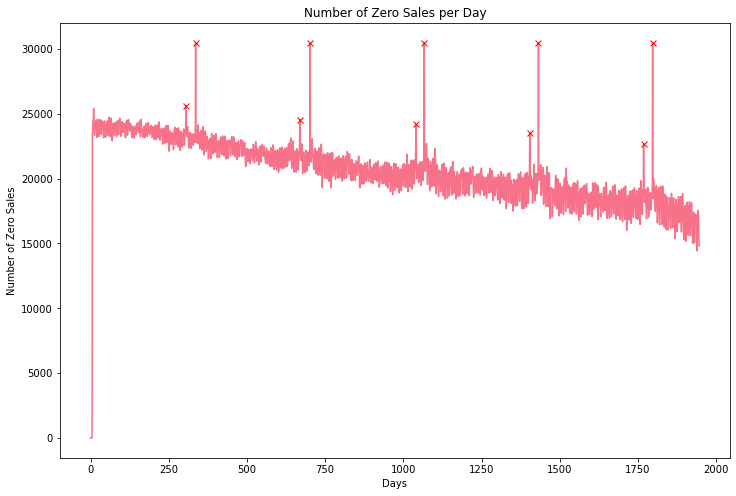

In [22]:
temp_series = sales_train_evaluation
plt.figure(figsize=(12,8))
peak_days = []
x = np.count_nonzero(temp_series==0, axis=0)
peaks, _ = sc.signal.find_peaks(x, height=np.quantile(x,0.75), threshold=max(x)/25)
peak_d = temp_series.columns[peaks]
peak_days=peak_d
plt.plot(x)
plt.plot(peaks, x[peaks], "x", color='red')
    
plt.title('Number of Zero Sales per Day')
plt.ylabel('Number of Zero Sales')
plt.xlabel('Days')

In [23]:
#df_prices = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv')
#df_days = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/calendar.csv')
calendar[calendar['d'].isin(peak_days)]


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
299,2011-11-24,11143,Thursday,6,11,2011,d_300,Thanksgiving,National,NaN,NaN,0,0,0
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,NaN,NaN,0,0,0
663,2012-11-22,11243,Thursday,6,11,2012,d_664,Thanksgiving,National,NaN,NaN,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0
1034,2013-11-28,11344,Thursday,6,11,2013,d_1035,Thanksgiving,National,NaN,NaN,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,NaN,NaN,0,0,0
1398,2014-11-27,11443,Thursday,6,11,2014,d_1399,Thanksgiving,National,NaN,NaN,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,NaN,NaN,0,0,0
1762,2015-11-26,11543,Thursday,6,11,2015,d_1763,Thanksgiving,National,NaN,NaN,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,NaN,NaN,0,0,0


In [24]:
peak_days_before=[]
peak_days_after=[]

for i, days in enumerate(peak_days):
    peak_days_before.append('d_'+str(np.int(peak_days[i][2:])-1))
    peak_days_after.append('d_'+str(np.int(peak_days[i][2:])+1))
df_train_no_outlier = sales_train_evaluation.copy().T[1:]
df_train_no_outlier.columns = sales_train_evaluation.T.iloc[0]

for x,y,z in zip(peak_days,peak_days_before,peak_days_after):
        df_train_no_outlier[df_train_no_outlier.index==x] = np.reshape([pd.concat([df_train_no_outlier[df_train_no_outlier.index==y],df_train_no_outlier[df_train_no_outlier.index==z]],axis=0).mean()],(1,30490))

df_train_no_outlier = df_train_no_outlier.T.reset_index()
df_train_no_outlier = pd.concat([df_train_no_outlier[level_cols],df_train_no_outlier[series_cols].apply(pd.to_numeric,downcast='float')],axis=1)

In [25]:
df_train_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: float32(1941), object(6)
memory usage: 227.2+ MB


Text(0.5, 0, 'Days')

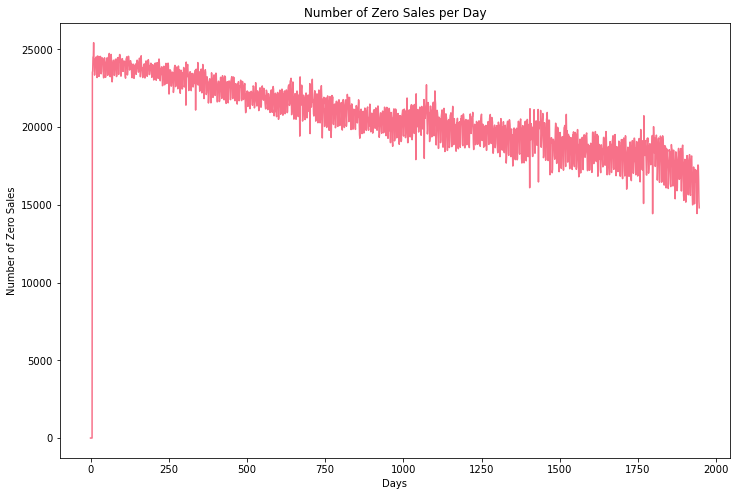

In [26]:
temp_series = df_train_no_outlier
plt.figure(figsize=(12,8))
x = np.count_nonzero(temp_series==0, axis=0)
plt.plot(x)
    
plt.title('Number of Zero Sales per Day')
plt.ylabel('Number of Zero Sales')
plt.xlabel('Days')

In [27]:
del temp_series, peak_days_before, peak_days_after, peak_d, peak_days, peaks

# Then move to the aggregation part. According to the table containing 12 levels, here comes the aggregation result with the dimension (42840,1941). Additionally, the result shoud be tested the correctness by comparing the row names: whether the combination of the levels is right and the rows contain the same input. The result turns that the aggregation is well designed and in the right order.

In [28]:
series_cols = df_train_no_outlier.columns[df_train_no_outlier.columns.str.contains("d_")].values
level_cols = df_train_no_outlier.columns[df_train_no_outlier.columns.str.contains("d_")==False].values


In [66]:
series_cols

array(['d_1', 'd_2', 'd_3', ..., 'd_1939', 'd_1940', 'd_1941'],
      dtype=object)

In [29]:
Level1 = pd.DataFrame(df_train_no_outlier[series_cols].sum(),columns={'Total'}).T
Level2 = df_train_no_outlier.groupby("state_id")[series_cols].sum()
Level3 = df_train_no_outlier.groupby("store_id")[series_cols].sum()
Level4 = df_train_no_outlier.groupby("cat_id")[series_cols].sum()
Level5 = df_train_no_outlier.groupby("dept_id")[series_cols].sum()

Level6 = df_train_no_outlier.groupby(["state_id",'cat_id'])[series_cols].sum().reset_index()
Level6['index']=''
for row in range(len(Level6)):
    Level6['index'][row]=str(Level6['state_id'][row])+'_'+str(Level6['cat_id'][row])
Level6.set_index(Level6['index'],inplace=True)
Level6.drop(['state_id','cat_id','index'],axis=1,inplace=True)

Level7 = df_train_no_outlier.groupby(["state_id",'dept_id'])[series_cols].sum().reset_index()
Level7['index']=''
for row in range(len(Level7)):
    Level7['index'][row]=str(Level7['state_id'][row])+'_'+str(Level7['dept_id'][row])
Level7.set_index(Level7['index'],inplace=True)
Level7.drop(['state_id','dept_id','index'],axis=1,inplace=True)

Level8 = df_train_no_outlier.groupby(["store_id",'cat_id'])[series_cols].sum().reset_index()
Level8['index']=''
for row in range(len(Level8)):
    Level8['index'][row]=str(Level8['store_id'][row])+'_'+str(Level8['cat_id'][row])
Level8.set_index(Level8['index'],inplace=True)
Level8.drop(['store_id','cat_id','index'],axis=1,inplace=True)

Level9 = df_train_no_outlier.groupby(["store_id",'dept_id'])[series_cols].sum().reset_index()
Level9['index']=''
for row in range(len(Level9)):
    Level9['index'][row]=str(Level9['store_id'][row])+'_'+str(Level9['dept_id'][row])
Level9.set_index(Level9['index'],inplace=True)
Level9.drop(['store_id','dept_id','index'],axis=1,inplace=True)

Level10= df_train_no_outlier.groupby(["item_id"])[series_cols].sum()


Level11= df_train_no_outlier.groupby(["item_id",'state_id'])[series_cols].sum().reset_index()
Level11['index']=''
for row in range(len(Level11)):
    Level11['index'][row]=str(Level11['item_id'][row])+'_'+str(Level11['state_id'][row])
Level11.set_index(Level11['index'],inplace=True)
Level11.drop(['item_id','state_id','index'],axis=1,inplace=True)


Level12= df_train_no_outlier.copy()
Level12.set_index(Level12['id'],inplace=True, drop =True)
Level12.drop(level_cols,axis=1,inplace=True)

df=pd.concat([Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12])

del Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12

In [30]:
test = pd.concat([df.reset_index()['index'],submission.reset_index().id[:42840]],axis=1)
test
test['index'].replace('_validation','',regex=True,inplace=True)

In [31]:
test['proof'] = ''
for row in range(len(test)):
    if test['index'][row] in test['id'][row]:
        test['proof'][row]=True
test[test['proof']==False]

,index,id,proof


In [32]:
df.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,...,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
Total,32631.0,31749.0,23783.0,25412.0,19146.0,29211.0,28010.0,37932.0,32736.0,25572.0,23071.0,23658.0,23756.0,26445.0,34833.0,36380.0,21804.0,24070.0,21443.0,20318.0,23721.0,31689.0,29283.0,23966.0,20501.0,20757.0,20277.0,22529.0,29908.0,28707.0,21240.0,22872.0,22046.0,23475.0,23572.0,31202.0,34876.0,24562.0,22752.0,22560.0,22626.0,25572.0,32225.0,31417.0,24935.0,24021.0,22765.0,21779.0,23855.0,30599.0,29643.0,23101.0,20492.0,19230.0,18854.0,23350.0,29620.0,29866.0,21449.0,19581.0,18928.0,21742.0,28309.0,33478.0,33058.0,24852.0,23581.0,22656.0,22901.0,24754.0,31745.0,31536.0,24829.0,23218.0,21611.0,21964.0,25482.0,29234.0,29787.0,22389.0,19474.0,20188.0,19768.0,24279.0,29575.0,24018.0,20004.0,18113.0,17929.0,18145.0,22735.0,28101.0,29045.0,22837.0,24080.0,20761.0,21184.0,24486.0,28412.0,23688.0,...,53715.0,48337.0,46152.0,37702.0,36545.0,36436.0,40392.0,50857.0,52081.0,37328.0,33981.0,34068.0,34615.0,37649.0,47887.0,50915.0,37259.0,36536.0,38458.0,41459.0,39325.0,52322.0,57218.0,40562.0,37727.0,37032.0,38267.0,40887.0,52711.0,51421.0,42035.0,40117.0,36606.0,35009.0,39652.0,46181.0,47825.0,37360.0,35475.0,34786.0,34003.0,45611.0,53863.0,46360.0,36041.0,33857.0,32359.0,34681.0,45536.0,52672.0,56425.0,40418.0,39683.0,39134.0,38116.0,43220.0,56340.0,53856.0,42427.0,39069.0,35193.0,37529.0,41789.0,48362.0,51640.0,38059.0,37570.0,35343.0,35033.0,40517.0,48962.0,49795.0,38793.0,35487.0,34445.0,34732.0,42896.0,50429.0,53032.0,43181.0,44314.0,39601.0,40763.0,43805.0,54239.0,45609.0,46400.0,39379.0,42248.0,40503.0,44073.0,54308.0,59921.0,42362.0,38777.0,37096.0,36963.0,42552.0,51518.0,54338.0
CA,14195.0,13805.0,10108.0,11047.0,9925.0,11322.0,12251.0,16610.0,14696.0,11822.0,10933.0,10350.0,11204.0,11354.0,14610.0,15630.0,9044.0,9496.0,8844.0,7835.0,10025.0,13870.0,13465.0,11997.0,9130.0,8941.0,8514.0,9847.0,13652.0,12491.0,9196.0,9782.0,9537.0,9710.0,10444.0,13784.0,16057.0,10953.0,10299.0,9951.0,10012.0,11189.0,13710.0,14340.0,10722.0,9293.0,9752.0,9504.0,10030.0,14509.0,14112.0,10255.0,9383.0,8490.0,7889.0,11011.0,13816.0,13661.0,9997.0,8516.0,8911.0,10059.0,12827.0,14791.0,15341.0,12356.0,10497.0,10101.0,10575.0,10971.0,14064.0,15291.0,11098.0,9181.0,8853.0,9430.0,10922.0,12809.0,13894.0,9955.0,8930.0,8582.0,8986.0,10967.0,13577.0,11721.0,8865.0,8176.0,8135.0,7951.0,9730.0,12428.0,12997.0,10657.0,10669.0,9596.0,9281.0,10617.0,12386.0,11231.0,...,21848.0,19238.0,19231.0,15249.0,14555.0,15306.0,17114.0,21348.0,22538.0,16269.0,14616.0,13943.0,14517.0,16346.0,21546.0,23157.0,16232.0,16297.0,15415.0,15621.0,16095.0,22022.0,25224.0,17148.0,16083.0,15544.0,15835.0,16275.0,22515.0,21937.0,16858.0,15051.0,14807.0,14196.0,16664.0,18900.0,19421.0,16541.0,15581.0,15141.0,15228.0,18694.0,23787.0,21296.0,15482.0,15319.0,14352.0,15601.0,18922.0,22171.0,24577.0,18193.0,16396.0

In [33]:
df.shape

(42840, 1941)

In [34]:
df

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,...,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
Total,32631.0,31749.0,23783.0,25412.0,19146.0,29211.0,28010.0,37932.0,32736.0,25572.0,23071.0,23658.0,23756.0,26445.0,34833.0,36380.0,21804.0,24070.0,21443.0,20318.0,23721.0,31689.0,29283.0,23966.0,20501.0,20757.0,20277.0,22529.0,29908.0,28707.0,21240.0,22872.0,22046.0,23475.0,23572.0,31202.0,34876.0,24562.0,22752.0,22560.0,22626.0,25572.0,32225.0,31417.0,24935.0,24021.0,22765.0,21779.0,23855.0,30599.0,29643.0,23101.0,20492.0,19230.0,18854.0,23350.0,29620.0,29866.0,21449.0,19581.0,18928.0,21742.0,28309.0,33478.0,33058.0,24852.0,23581.0,22656.0,22901.0,24754.0,31745.0,31536.0,24829.0,23218.0,21611.0,21964.0,25482.0,29234.0,29787.0,22389.0,19474.0,20188.0,19768.0,24279.0,29575.0,24018.0,20004.0,18113.0,17929.0,18145.0,22735.0,28101.0,29045.0,22837.0,24080.0,20761.0,21184.0,24486.0,28412.0,23688.0,...,53715.0,48337.0,46152.0,37702.0,36545.0,36436.0,40392.0,50857.0,52081.0,37328.0,33981.0,34068.0,34615.0,37649.0,47887.0,50915.0,37259.0,36536.0,38458.0,41459.0,39325.0,52322.0,57218.0,40562.0,37727.0,37032.0,38267.0,40887.0,52711.0,51421.0,42035.0,40117.0,36606.0,35009.0,39652.0,46181.0,47825.0,37360.0,35475.0,34786.0,34003.0,45611.0,53863.0,46360.0,36041.0,33857.0,32359.0,34681.0,45536.0,52672.0,56425.0,40418.0,39683.0,39134.0,38116.0,43220.0,56340.0,53856.0,42427.0,39069.0,35193.0,37529.0,41789.0,48362.0,51640.0,38059.0,37570.0,35343.0,35033.0,40517.0,48962.0,49795.0,38793.0,35487.0,34445.0,34732.0,42896.0,50429.0,53032.0,43181.0,44314.0,39601.0,40763.0,43805.0,54239.0,45609.0,46400.0,39379.0,42248.0,40503.0,44073.0,54308.0,59921.0,42362.0,38777.0,37096.0,36963.0,42552.0,51518.0,54338.0
CA,14195.0,13805.0,10108.0,11047.0,9925.0,11322.0,12251.0,16610.0,14696.0,11822.0,10933.0,10350.0,11204.0,11354.0,14610.0,15630.0,9044.0,9496.0,8844.0,7835.0,10025.0,13870.0,13465.0,11997.0,9130.0,8941.0,8514.0,9847.0,13652.0,12491.0,9196.0,9782.0,9537.0,9710.0,10444.0,13784.0,16057.0,10953.0,10299.0,9951.0,10012.0,11189.0,13710.0,14340.0,10722.0,9293.0,9752.0,9504.0,10030.0,14509.0,14112.0,10255.0,9383.0,8490.0,7889.0,11011.0,13816.0,13661.0,9997.0,8516.0,8911.0,10059.0,12827.0,14791.0,15341.0,12356.0,10497.0,10101.0,10575.0,10971.0,14064.0,15291.0,11098.0,9181.0,8853.0,9430.0,10922.0,12809.0,13894.0,9955.0,8930.0,8582.0,8986.0,10967.0,13577.0,11721.0,8865.0,8176.0,8135.0,7951.0,9730.0,12428.0,12997.0,10657.0,10669.0,9596.0,9281.0,10617.0,12386.0,11231.0,...,21848.0,19238.0,19231.0,15249.0,14555.0,15306.0,17114.0,21348.0,22538.0,16269.0,14616.0,13943.0,14517.0,16346.0,21546.0,23157.0,16232.0,16297.0,15415.0,15621.0,16095.0,22022.0,25224.0,17148.0,16083.0,15544.0,15835.0,16275.0,22515.0,21937.0,16858.0,15051.0,14807.0,14196.0,16664.0,18900.0,19421.0,16541.0,15581.0,15141.0,15228.0,18694.0,23787.0,21296.0,15482.0,15319.0,14352.0,15601.0,18922.0,22171.0,24577.0,18193.0,16396.0

## Feature Enginering
### Here, we add several features to the calendar data set containing: whether the day is the event day, whether the day is before the event day and the unit sale from the file of sale training.  Moreover, take prices per product per week into account. However, if simply considering the weekly prices, there are 3049 products * 10 stores, leading to 30490 additional columns. So, we decide to group the price by store and category. As a result, there are 10 stores * 3 categories, leading to only 30 additional columns. Of course, we have firstly finished encoding the categorical variables event name and event type into numbers. After merging all the features, we fill the blank with the value in the latter one and give normalization to the whole data set of the features.



In [35]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [36]:
timesteps = 14
startDay = 0
calendar['date'] = pd.to_datetime(calendar['date'],format='%Y-%m-%d')
calendar.set_index('date', inplace=True)

calendar['is_event_day'] = [1 if x ==False else 0 for x in calendar['event_name_1'].isnull()] 
calendar['is_event_day'] = calendar['is_event_day'].astype(np.int8)
#找节日前的日期
day_before_event = calendar[calendar['is_event_day']==1].index.shift(-1,freq='D')
calendar['is_event_day_before'] = 0
calendar['is_event_day_before'][calendar.index.isin(day_before_event)] = 1
calendar['is_event_day_before'] = calendar['is_event_day_before'].astype(np.int8)

del day_before_event



In [37]:
#encode
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop([ "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])

    return df

df_days = prep_calendar(calendar)

In [38]:
df_days

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event_day,is_event_day_before
date,,,,,,,,,,,,,,
2011-01-29,11101,0,0,0,1,30,4,4,2,0,0,0,0,0
2011-01-30,11101,1,0,0,2,30,4,4,2,0,0,0,0,0
2011-01-31,11101,2,0,0,3,30,4,4,2,0,0,0,0,0
2011-02-01,11101,3,1,0,4,30,4,4,2,1,1,0,0,0
2011-02-02,11101,4,1,0,5,30,4,4,2,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,4,5,5,1965,30,4,4,2,0,1,1,0,0
2016-06-16,11620,5,5,5,1966,30,4,4,2,0,0,0,0,0
2016-06-17,11620,6,5,5,1967,30,4,4,2,0,0,0,0,0


In [39]:
#1919 1947
cat_cols = [#"wm_yr_wk",
            "wday", "month", "year", "event_name_1", 
            "event_type_1", "event_name_2", "event_type_2",
            "is_event_day_before", "snap_CA", "snap_TX", "snap_WI"]
features = df_days[cat_cols]

## For Testing
#features_test = features.iloc[1913:1941,:]
#features_train = features.iloc[startDay:1913,:]

## For final prediction:
#features_test = features.iloc[1941:,:]
#features_train = features.iloc[startDay:1941]

## For Testing (Validation Dataset)
#df_final = pd.concat([df.T.reset_index(drop=True).iloc[startDay:1913,:], features.iloc[startDay:1913,:].reset_index(drop=True)], axis = 1)

## For final prediction (Evaluation Dataset):
#df_final = pd.concat([df.T.reset_index(drop=True).iloc[startDay:1941,:], features.iloc[startDay:1941,:].reset_index(drop=True)], axis = 1)
df_final=pd.concat([df.T.reset_index(drop=True),features.iloc[0:1941,:].reset_index(drop=True)],axis=1)

numeric_cols = df_final[df_final.columns.difference(cat_cols)].columns

In [40]:
df_final

,Total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD,CA_FOODS_1,CA_FOODS_2,CA_FOODS_3,CA_HOBBIES_1,CA_HOBBIES_2,CA_HOUSEHOLD_1,CA_HOUSEHOLD_2,TX_FOODS_1,TX_FOODS_2,TX_FOODS_3,TX_HOBBIES_1,TX_HOBBIES_2,TX_HOUSEHOLD_1,TX_HOUSEHOLD_2,WI_FOODS_1,WI_FOODS_2,WI_FOODS_3,WI_HOBBIES_1,WI_HOBBIES_2,WI_HOUSEHOLD_1,WI_HOUSEHOLD_2,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,CA_2_HOBBIES_1,CA_2_HOBBIES_2,CA_2_HOUSEHOLD_1,CA_2_HOUSEHOLD_2,CA_3_FOODS_1,CA_3_FOODS_2,...,FOODS_3_738_WI_3_evaluation,FOODS_3_739_WI_3_evaluation,FOODS_3_741_WI_3_evaluation,FOODS_3_742_WI_3_evaluation,FOODS_3_743_WI_3_evaluation,FOODS_3_744_WI_3_evaluation,FOODS_3_745_WI_3_evaluation,FOODS_3_746_WI_3_evaluation,FOODS_3_747_WI_3_evaluation,FOODS_3_748_WI_3_evaluation,FOODS_3_749_WI_3_evaluation,FOODS_3_750_WI_3_evaluation,FOODS_3_751_WI_3_evaluation,FOODS_3_752_WI_3_evaluation,FOODS_3_753_WI_3_evaluation,FOODS_3_754_WI_3_evaluation,FOODS_3_755_WI_3_evaluation,FOODS_3_756_WI_3_evaluation,FOODS_3_757_WI_3_evaluation,FOODS_3_758_WI_3_evaluation,FOODS_3_759_WI_3_evaluation,FOODS_3_760_WI_3_evaluation,FOODS_3_761_WI_3_evaluation,FOODS_3_762_WI_3_evaluation,FOODS_3_763_WI_3_evaluation,FOODS_3_764_WI_3_evaluation,FOODS_3_765_WI_3_evaluation,FOODS_3_766_WI_3_evaluation,FOODS_3_767_WI_3_evaluation,FOODS_3_768_WI_3_evaluation,FOODS_3_769_WI_3_evaluation,FOODS_3_770_WI_3_evaluation,FOODS_3_771_WI_3_evaluation,FOODS_3_772_WI_3_evaluation,FOODS_3_773_WI_3_evaluation,FOODS_3_774_WI_3_evaluation,FOODS_3_775_WI_3_evaluation,FOODS_3_776_WI_3_evaluation,FOODS_3_777_WI_3_evaluation,FOODS_3_778_WI_3_evaluation,FOODS_3_779_WI_3_evaluation,FOODS_3_780_WI_3_evaluation,FOODS_3_781_WI_3_evaluation,FOODS_3_782_WI_3_evaluation,FOODS_3_783_WI_3_evaluation,FOODS_3_784_WI_3_evaluation,FOODS_3_785_WI_3_evaluation,FOODS_3_786_WI_3_evaluation,FOODS_3_787_WI_3_evaluation,FOODS_3_788_WI_3_evaluation,FOODS_3_789_WI_3_evaluation,FOODS_3_790_WI_3_evaluation,FOODS_3_791_WI_3_evaluation,FOODS_3_792_WI_3_evaluation,FOODS_3_793_WI_3_evaluation,FOODS_3_794_WI_3_evaluation,FOODS_3_795_WI_3_evaluation,FOODS_3_796_WI_3_evaluation,FOODS_3_797_WI_3_evaluation,FOODS_3_798_WI_3_evaluation,FOODS_3_799_WI_3_evaluation,FOODS_3_800_WI_3_evaluation,FOODS_3_801_WI_3_evaluation,FOODS_3_802_WI_3_evaluation,FOODS_3_803_WI_3_evaluation,FOODS_3_804_WI_3_evaluation,FOODS_3_805_WI_3_evaluation,FOODS_3_806_WI_3_evaluation,FOODS_3_807_WI_3_evaluation,FOODS_3_808_WI_3_evaluation,FOODS_3_809_WI_3_evaluation,FOODS_3_810_WI_3_evaluation,FOODS_3_811_WI_3_evaluation,FOODS_3_812_WI_3_evaluation,FOODS_3_813_WI_3_evaluation,FOODS_3_814_WI_3_evaluation,FOODS_3_815_WI_3_evaluation,FOODS_3_816_WI_3_evaluation,FOODS_3_817_WI_3_evaluation,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,is_event_day_before,snap_CA,snap_TX,snap_WI
0,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,2556.0,3852.0,3030.0,2704.0,2256.0,4038.0,23178.0,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,10101.0,1802.0,2292.0,6853.0,879.0,1706.0,6224.0,1083.0,1691.0,1157.0,186

# 加入价格

In [41]:
#### adding 'id' column as well as 'cat_id', 'dept_id' and 'state_id', then changing the type to 'categorical'
sell_price.loc[:, "id"] = sell_price.loc[:, "item_id"] + "_" + sell_price.loc[:, "store_id"] + "_validation"
sell_price['state_id'] = sell_price['store_id'].str.split('_',expand=True)[0]
sell_price = pd.concat([sell_price, sell_price["item_id"].str.split("_", expand=True)], axis=1)
sell_price = sell_price.rename(columns={0:"cat_id", 1:"dept_id"})
sell_price[["store_id", "item_id", "cat_id", "dept_id", 'state_id']] = sell_price[["store_id","item_id", "cat_id", "dept_id", 'state_id']].astype("category")
sell_price = sell_price.drop(columns=2)

In [42]:
price_features = pd.DataFrame(sell_price.groupby(['wm_yr_wk','store_id','cat_id'])['sell_price'].mean().reset_index())
price_features['sell_price'] = price_features['sell_price'].astype('float32')
price_features['store_cat'] = 0
for row in range(len(price_features)):
     price_features['store_cat'][row]=str(price_features['store_id'][row])+'_'+str(price_features['cat_id'][row])
        
price_features= price_features.pivot(index='store_cat',columns='wm_yr_wk',values='sell_price').T
price_features.head()

store_cat,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD
wm_yr_wk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11101,3.149220,4.468814,5.416100,2.876585,4.606471,5.560200,3.041969,4.586119,5.614755,2.953270,5.055555,5.457537,2.948958,4.674835,5.318895,2.956474,4.690149,5.460627,2.929892,4.740829,5.291948,2.759773,4.634844,5.472965,2.807157,4.869885,5.464807,2.987332,4.523247,5.262981
11102,3.153394,4.406516,5.509580,2.878910,4.595953,5.633388,3.059110,4.556830,5.632422,3.050711,5.108013,5.616110,2.982808,4.668509,5.440688,2.987700,4.641878,5.467119,2.983471,4.721096,5.467833,2.803158,4.696573,5.603652,2.861577,4.882676,5.703397,3.023365,4.623829,5.383163
11103,3.129630,4.459240,5.578825,2.868239,4.518189,5.597704,3.069272,4.488542,5.676674,3.058299,5.015818,5.624559,2.985073,4.584755,5.469819,2.987307,4.606833,5.558901,3.004687,4.741762,5.515718,2.831856,4.555905,5.593923,2.859043,4.809469,5.770275,3.057585,4.550339,5.435507
11104,3.123212,4.422090,5.580215,2.860965,4.526144,5.591329,3.078915,4.486432,5.664989,3.064828,5.011198,5.668639,2.984580,4.541724,5.475885,2.991057,4.549258,5.546131,2.997962,4.746883,5.566806,2.822036,4.532754,5.633510,2.881155,4.761277,5.813060,3.057149,4.495466,5.514427
11105,3.125868,4.434672,5.566356,2.854346,4.539578,5.592275,3.081788,4.469349,5.687873,3.070062,5.003787,5.665695,2.973670,4.552069,5.537656,2.984856,4.478067,5.571553,2.989463,4.749264,5.584891,2.820916,4.515333,5.672668,2.889262,4.752236,5.841174,3.041605,4.493952,5.506074


In [43]:
price_features

store_cat,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD
wm_yr_wk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11101,3.149220,4.468814,5.416100,2.876585,4.606471,5.560200,3.041969,4.586119,5.614755,2.953270,5.055555,5.457537,2.948958,4.674835,5.318895,2.956474,4.690149,5.460627,2.929892,4.740829,5.291948,2.759773,4.634844,5.472965,2.807157,4.869885,5.464807,2.987332,4.523247,5.262981
11102,3.153394,4.406516,5.509580,2.878910,4.595953,5.633388,3.059110,4.556830,5.632422,3.050711,5.108013,5.616110,2.982808,4.668509,5.440688,2.987700,4.641878,5.467119,2.983471,4.721096,5.467833,2.803158,4.696573,5.603652,2.861577,4.882676,5.703397,3.023365,4.623829,5.383163
11103,3.129630,4.459240,5.578825,2.868239,4.518189,5.597704,3.069272,4.488542,5.676674,3.058299,5.015818,5.624559,2.985073,4.584755,5.469819,2.987307,4.606833,5.558901,3.004687,4.741762,5.515718,2.831856,4.555905,5.593923,2.859043,4.809469,5.770275,3.057585,4.550339,5.435507
11104,3.123212,4.422090,5.580215,2.860965,4.526144,5.591329,3.078915,4.486432,5.664989,3.064828,5.011198,5.668639,2.984580,4.541724,5.475885,2.991057,4.549258,5.546131,2.997962,4.746883,5.566806,2.822036,4.532754,5.633510,2.881155,4.761277,5.813060,3.057149,4.495466,5.514427
11105,3.125868,4.434672,5.566356,2.854346,4.539578,5.592275,3.081788,4.469349,5.687873,3.070062,5.003787,5.665695,2.973670,4.552069,5.537656,2.984856,4.478067,5.571553,2.989463,4.749264,5.584891,2.820916,4.515333,5.672668,2.889262,4.752236,5.841174,3.041605,4.493952,5.506074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11617,3.347112,5.560814,5.474651,3.345964,5.562018,5.470831,3.344906,5.561080,5.470468,3.347745,5.560637,5.475616,3.317223,5.494425,5.462923,3.321921,5.492372,5.464021,3.323521,5.495487,5.463066,3.363716,5.543682,5.475616,3.365964,5.550443,5.469723,3.364440,5.547080,5.459102
11618,3.347369,5.561380,5.474651,3.346994,5.560796,5.469876,3.345699,5.560832,5.469513,3.347738,5.561203,5.474661,3.325324,5.496141,5.462598,3.320418,5.485593,5.462121,3.324607,5.495770,5.463066,3.365435,5.544248,5.476180,3.366075,5.549788,5.471939,3.365365,5.548265,5.464766
11619,3.349165,5.561735,5.474651,3.348552,5.560796,5.474651,3.348379,5.556867,5.471490,3.349576,5.561681,5.474651,3.324147,5.496389,5.463543,3.324405,5.486743,5.463543,3.327822,5.495770,5.463543,3.368490,5.544248,5.476180,3.367989,5.546159,5.471939,3.367815,5.550460,5.464957


In [44]:
features

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,is_event_day_before,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,
2011-01-29,0,0,0,30,4,4,2,0,0,0,0
2011-01-30,1,0,0,30,4,4,2,0,0,0,0
2011-01-31,2,0,0,30,4,4,2,0,0,0,0
2011-02-01,3,1,0,30,4,4,2,0,1,1,0
2011-02-02,4,1,0,30,4,4,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,4,5,5,30,4,4,2,0,0,1,1
2016-06-16,5,5,5,30,4,4,2,0,0,0,0
2016-06-17,6,5,5,30,4,4,2,0,0,0,0


In [45]:
#features = pd.merge(features.reset_index(),price_features,how='left', left_on='wm_yr_wk', right_on='wm_yr_wk').set_index('date')
#features.drop('wm_yr_wk', axis=1, inplace=True)
#features.fillna(method = 'bfill', inplace=True)
#features.head()
##features_test = features1.iloc[1913:1941,:]
##features_train = features1.iloc[startDay:1913,:]
##features_train = features1
#df_final = pd.concat([df.T.reset_index(drop=True), features.iloc[0:1941,:].reset_index(drop=True)], axis = 1)



In [47]:
#df_valid = df.T.reset_index(drop=True).iloc[1913:,:]
#features_valid = features.iloc[1941:,:]

print(df_final.shape)
df_final.head()

(1941, 42851)


,Total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD,CA_FOODS_1,CA_FOODS_2,CA_FOODS_3,CA_HOBBIES_1,CA_HOBBIES_2,CA_HOUSEHOLD_1,CA_HOUSEHOLD_2,TX_FOODS_1,TX_FOODS_2,TX_FOODS_3,TX_HOBBIES_1,TX_HOBBIES_2,TX_HOUSEHOLD_1,TX_HOUSEHOLD_2,WI_FOODS_1,WI_FOODS_2,WI_FOODS_3,WI_HOBBIES_1,WI_HOBBIES_2,WI_HOUSEHOLD_1,WI_HOUSEHOLD_2,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,CA_2_HOBBIES_1,CA_2_HOBBIES_2,CA_2_HOUSEHOLD_1,CA_2_HOUSEHOLD_2,CA_3_FOODS_1,CA_3_FOODS_2,...,FOODS_3_738_WI_3_evaluation,FOODS_3_739_WI_3_evaluation,FOODS_3_741_WI_3_evaluation,FOODS_3_742_WI_3_evaluation,FOODS_3_743_WI_3_evaluation,FOODS_3_744_WI_3_evaluation,FOODS_3_745_WI_3_evaluation,FOODS_3_746_WI_3_evaluation,FOODS_3_747_WI_3_evaluation,FOODS_3_748_WI_3_evaluation,FOODS_3_749_WI_3_evaluation,FOODS_3_750_WI_3_evaluation,FOODS_3_751_WI_3_evaluation,FOODS_3_752_WI_3_evaluation,FOODS_3_753_WI_3_evaluation,FOODS_3_754_WI_3_evaluation,FOODS_3_755_WI_3_evaluation,FOODS_3_756_WI_3_evaluation,FOODS_3_757_WI_3_evaluation,FOODS_3_758_WI_3_evaluation,FOODS_3_759_WI_3_evaluation,FOODS_3_760_WI_3_evaluation,FOODS_3_761_WI_3_evaluation,FOODS_3_762_WI_3_evaluation,FOODS_3_763_WI_3_evaluation,FOODS_3_764_WI_3_evaluation,FOODS_3_765_WI_3_evaluation,FOODS_3_766_WI_3_evaluation,FOODS_3_767_WI_3_evaluation,FOODS_3_768_WI_3_evaluation,FOODS_3_769_WI_3_evaluation,FOODS_3_770_WI_3_evaluation,FOODS_3_771_WI_3_evaluation,FOODS_3_772_WI_3_evaluation,FOODS_3_773_WI_3_evaluation,FOODS_3_774_WI_3_evaluation,FOODS_3_775_WI_3_evaluation,FOODS_3_776_WI_3_evaluation,FOODS_3_777_WI_3_evaluation,FOODS_3_778_WI_3_evaluation,FOODS_3_779_WI_3_evaluation,FOODS_3_780_WI_3_evaluation,FOODS_3_781_WI_3_evaluation,FOODS_3_782_WI_3_evaluation,FOODS_3_783_WI_3_evaluation,FOODS_3_784_WI_3_evaluation,FOODS_3_785_WI_3_evaluation,FOODS_3_786_WI_3_evaluation,FOODS_3_787_WI_3_evaluation,FOODS_3_788_WI_3_evaluation,FOODS_3_789_WI_3_evaluation,FOODS_3_790_WI_3_evaluation,FOODS_3_791_WI_3_evaluation,FOODS_3_792_WI_3_evaluation,FOODS_3_793_WI_3_evaluation,FOODS_3_794_WI_3_evaluation,FOODS_3_795_WI_3_evaluation,FOODS_3_796_WI_3_evaluation,FOODS_3_797_WI_3_evaluation,FOODS_3_798_WI_3_evaluation,FOODS_3_799_WI_3_evaluation,FOODS_3_800_WI_3_evaluation,FOODS_3_801_WI_3_evaluation,FOODS_3_802_WI_3_evaluation,FOODS_3_803_WI_3_evaluation,FOODS_3_804_WI_3_evaluation,FOODS_3_805_WI_3_evaluation,FOODS_3_806_WI_3_evaluation,FOODS_3_807_WI_3_evaluation,FOODS_3_808_WI_3_evaluation,FOODS_3_809_WI_3_evaluation,FOODS_3_810_WI_3_evaluation,FOODS_3_811_WI_3_evaluation,FOODS_3_812_WI_3_evaluation,FOODS_3_813_WI_3_evaluation,FOODS_3_814_WI_3_evaluation,FOODS_3_815_WI_3_evaluation,FOODS_3_816_WI_3_evaluation,FOODS_3_817_WI_3_evaluation,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,is_event_day_before,snap_CA,snap_TX,snap_WI
0,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,2556.0,3852.0,3030.0,2704.0,2256.0,4038.0,23178.0,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,10101.0,1802.0,2292.0,6853.0,879.0,1706.0,6224.0,1083.0,1691.0,1157.0,186

In [64]:
#df_final.to_csv("df_final.csv")


In [48]:
#Normalization

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(df_final)

In [49]:
dt_scaled.shape

(1941, 42851)

In [50]:
dt_scaled

array([[0.35011431, 0.36574846, 0.30447471, ..., 0.        , 0.        ,
        0.        ],
       [0.32911031, 0.34332049, 0.31884166, ..., 0.        , 0.        ,
        0.        ],
       [0.13940751, 0.13071482, 0.10543251, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.58637359, 0.55178561, 0.51885663, ..., 0.        , 0.        ,
        0.        ],
       [0.79989046, 0.87802634, 0.62196947, ..., 0.        , 0.        ,
        0.        ],
       [0.8670461 , 0.96664558, 0.7068243 , ..., 0.        , 0.        ,
        0.        ]])

In [63]:
np.savetxt("dt_scaledtxt.txt",dt_scaled)


## 没有embedding 的model

In [61]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:42840]) 
    
X_train = np.array(X_train)
y_train = np.array(y_train)
print('Shape of X_train :'+str(X_train.shape))
print('Shape of y_train :'+str(y_train.shape))

Shape of X_train :(1899, 14, 42851)
Shape of y_train :(1899, 42840)


In [62]:
inputs = df_final[-timesteps:]
#inputs = sc.transform(inputs)

In [ ]:
timesteps = 14
startDay = 0
import keras
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)
QUANTILES = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
EPOCHS = 32 # going through the dataset 32 times
BATCH_SIZE = 32 # with each training step the model sees 32 examples
# Importing the Keras libraries and packages
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, Embedding, Flatten, concatenate

from keras.models import Sequential
def run_model(X_train, y_train, q):

    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=40
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=400
    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=400
    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))
    # Compiling the RNN
    model.compile(optimizer = 'adam',loss=lambda y, f: tilted_loss(q, y, f))
    
    # To follow at which quantile we are predicting right now  
    print('Running the model for Quantil: '+str(q)+':')

    # Fitting the RNN to the Training set
    fit = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=2)
    
    X_test = []
    X_test.append(inputs[0:timesteps])
    X_test = np.array(X_test)
    prediction = []
     
    for j in range(timesteps,timesteps + 28):
        predicted_volume = model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 42841)) #incl. features
        testInput = np.column_stack((np.array(predicted_volume), np.array(features_test.iloc[j-timesteps,:]).reshape(1,1))) #here no of features is 5
        X_test = np.append(X_test, testInput).reshape(1,j + 1,42841) #incl. features
        predicted_volume = sc.inverse_transform(testInput)[:,0:42840] #without features
        prediction.append(predicted_volume)
    
    prediction = pd.DataFrame(data=np.array(prediction).reshape(28,42840)).T
    
    return prediction

In [ ]:
predictions = pd.concat(
    [run_model(X_train, y_train, q) 
     for q in QUANTILES]) 

In [ ]:
predictions.shape

# MODEL with embedding

In [51]:
timesteps = 14
startDay = 0
X_train = []
y_train = []
X_train_categories= {}

#X_train_prices = []


# creating a dict for all categorical varialbes
for cats in cat_cols:
    X_train_categories[cats] = []

# Creating X-train, y_train and X_train_categories - here already for final prediction (1941)
for i in range(timesteps, 1941 - startDay):
    X_train.append(dt_scaled[i-timesteps:i,0:42840])
    y_train.append(dt_scaled[i][0:42840])
    
    for z, cats in enumerate(cat_cols):
        X_train_categories[cats].append(dt_scaled[i-timesteps:i,42840+z])
    
#    X_train_prices.append(dt_scaled[i-timesteps:i,42851:])

    
X_train = np.array(X_train)
y_train = np.array(y_train)

#X_train_prices = np.array(X_train_prices)

print('Shape of X_train: '+str(X_train.shape))
print('Shape of y_train: '+str(y_train.shape))
print('Shape of all categorical features: '+str(np.array(X_train_categories[cats]).shape))

#print('Shape of price feature: '+str(X_train_prices.shape))

Shape of X_train: (1927, 14, 42840)
Shape of y_train: (1927, 42840)
Shape of all categorical features: (1927, 14)


In [52]:
df_final

,Total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD,CA_FOODS_1,CA_FOODS_2,CA_FOODS_3,CA_HOBBIES_1,CA_HOBBIES_2,CA_HOUSEHOLD_1,CA_HOUSEHOLD_2,TX_FOODS_1,TX_FOODS_2,TX_FOODS_3,TX_HOBBIES_1,TX_HOBBIES_2,TX_HOUSEHOLD_1,TX_HOUSEHOLD_2,WI_FOODS_1,WI_FOODS_2,WI_FOODS_3,WI_HOBBIES_1,WI_HOBBIES_2,WI_HOUSEHOLD_1,WI_HOUSEHOLD_2,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,CA_2_HOBBIES_1,CA_2_HOBBIES_2,CA_2_HOUSEHOLD_1,CA_2_HOUSEHOLD_2,CA_3_FOODS_1,CA_3_FOODS_2,...,FOODS_3_738_WI_3_evaluation,FOODS_3_739_WI_3_evaluation,FOODS_3_741_WI_3_evaluation,FOODS_3_742_WI_3_evaluation,FOODS_3_743_WI_3_evaluation,FOODS_3_744_WI_3_evaluation,FOODS_3_745_WI_3_evaluation,FOODS_3_746_WI_3_evaluation,FOODS_3_747_WI_3_evaluation,FOODS_3_748_WI_3_evaluation,FOODS_3_749_WI_3_evaluation,FOODS_3_750_WI_3_evaluation,FOODS_3_751_WI_3_evaluation,FOODS_3_752_WI_3_evaluation,FOODS_3_753_WI_3_evaluation,FOODS_3_754_WI_3_evaluation,FOODS_3_755_WI_3_evaluation,FOODS_3_756_WI_3_evaluation,FOODS_3_757_WI_3_evaluation,FOODS_3_758_WI_3_evaluation,FOODS_3_759_WI_3_evaluation,FOODS_3_760_WI_3_evaluation,FOODS_3_761_WI_3_evaluation,FOODS_3_762_WI_3_evaluation,FOODS_3_763_WI_3_evaluation,FOODS_3_764_WI_3_evaluation,FOODS_3_765_WI_3_evaluation,FOODS_3_766_WI_3_evaluation,FOODS_3_767_WI_3_evaluation,FOODS_3_768_WI_3_evaluation,FOODS_3_769_WI_3_evaluation,FOODS_3_770_WI_3_evaluation,FOODS_3_771_WI_3_evaluation,FOODS_3_772_WI_3_evaluation,FOODS_3_773_WI_3_evaluation,FOODS_3_774_WI_3_evaluation,FOODS_3_775_WI_3_evaluation,FOODS_3_776_WI_3_evaluation,FOODS_3_777_WI_3_evaluation,FOODS_3_778_WI_3_evaluation,FOODS_3_779_WI_3_evaluation,FOODS_3_780_WI_3_evaluation,FOODS_3_781_WI_3_evaluation,FOODS_3_782_WI_3_evaluation,FOODS_3_783_WI_3_evaluation,FOODS_3_784_WI_3_evaluation,FOODS_3_785_WI_3_evaluation,FOODS_3_786_WI_3_evaluation,FOODS_3_787_WI_3_evaluation,FOODS_3_788_WI_3_evaluation,FOODS_3_789_WI_3_evaluation,FOODS_3_790_WI_3_evaluation,FOODS_3_791_WI_3_evaluation,FOODS_3_792_WI_3_evaluation,FOODS_3_793_WI_3_evaluation,FOODS_3_794_WI_3_evaluation,FOODS_3_795_WI_3_evaluation,FOODS_3_796_WI_3_evaluation,FOODS_3_797_WI_3_evaluation,FOODS_3_798_WI_3_evaluation,FOODS_3_799_WI_3_evaluation,FOODS_3_800_WI_3_evaluation,FOODS_3_801_WI_3_evaluation,FOODS_3_802_WI_3_evaluation,FOODS_3_803_WI_3_evaluation,FOODS_3_804_WI_3_evaluation,FOODS_3_805_WI_3_evaluation,FOODS_3_806_WI_3_evaluation,FOODS_3_807_WI_3_evaluation,FOODS_3_808_WI_3_evaluation,FOODS_3_809_WI_3_evaluation,FOODS_3_810_WI_3_evaluation,FOODS_3_811_WI_3_evaluation,FOODS_3_812_WI_3_evaluation,FOODS_3_813_WI_3_evaluation,FOODS_3_814_WI_3_evaluation,FOODS_3_815_WI_3_evaluation,FOODS_3_816_WI_3_evaluation,FOODS_3_817_WI_3_evaluation,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,is_event_day_before,snap_CA,snap_TX,snap_WI
0,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,2556.0,3852.0,3030.0,2704.0,2256.0,4038.0,23178.0,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,10101.0,1802.0,2292.0,6853.0,879.0,1706.0,6224.0,1083.0,1691.0,1157.0,186

In [53]:
#考虑是否去掉column

In [54]:
inputs = {}
inputs.update({'numerics': dt_scaled[-timesteps:,:42840]})
for cats in cat_cols:
    inputs[cats] = []

for z, cats in enumerate(cat_cols):
    inputs.update({cats: dt_scaled[-timesteps:,42840+z]})
        
#inputs.update({'prices':df_final.iloc[-timesteps:,-30490:].to_numpy()})

## 进入模型

In [80]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [81]:
QUANTILES=[0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995]
EPOCH=30                    #32
BATCH_SIZE=44
from keras.models import Model
from keras.layers import Dense, LSTM,Dropout,Input,Flatten,concatenate,Embedding

In [82]:
#identifying uniques for each of the categorical features
feat_uniques = []
for feats in features.iloc[:,:len(cat_cols)]:
    feat_uniques.append(df_final[feats].nunique())
    
#num_cats = features.shape[1] # number of categorical features
n_steps = X_train.shape[1] # number of timesteps in each sample
n_numerical_feats = len(numeric_cols) # number of numerical features in each sample
cat_size = feat_uniques # number of categories in each categorical feature
cat_embd_dim = list(np.ones(len(cat_cols), dtype=np.int8)) # embedding dimension for each categorical feature

numerical_input = Input(shape=(n_steps, n_numerical_feats), name='numeric_input')

cat_inputs = []
for i,cat in enumerate(cat_cols):
    cat_inputs.append(Input(shape=(n_steps,), name=cat + '_input'))

cat_embedded = []

In [112]:
tf.compat.v1.disable_eager_execution()
sess =tf.compat.v1.Session()

In [ ]:
#identifying uniques for each of the categorical features
feat_uniques = []
for feats in features.iloc[:,:len(cat_cols)]:
    feat_uniques.append(df_final[feats].nunique())
    
#num_cats = features.shape[1] # number of categorical features
n_steps = X_train.shape[1] # number of timesteps in each sample
n_numerical_feats = len(numeric_cols) # number of numerical features in each sample
cat_size = feat_uniques # number of categories in each categorical feature
cat_embd_dim = list(np.ones(len(cat_cols), dtype=np.int8)) # embedding dimension for each categorical feature

numerical_input = Input(shape=(n_steps, n_numerical_feats), name='numeric_input')

cat_inputs = []
for i,cat in enumerate(cat_cols):
    cat_inputs.append(Input(shape=(n_steps,), name=cat + '_input'))

cat_embedded = []
#for i,cat in enumerate(cat_cols):
#    embed = Flatten()(Embedding(cat_size[i], cat_embd_dim[i])(cat_inputs[i]))
#    cat_embedded.append(embed)
    
for i,cat in enumerate(cat_cols):
    embed = Embedding(cat_size[i], cat_embd_dim[i])(cat_inputs[i])
    cat_embedded.append(embed)

cat_merged = concatenate(cat_embedded)

#prices_input = Input(shape=(n_steps, len(price_features.columns)), name='prices_input')

#merged = concatenate([numerical_input, cat_merged, prices_input])

merged = concatenate([numerical_input, cat_merged])


# Adding the first layer
lstm_out = LSTM(40, dropout=0.2, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))(merged)
# Adding a second layer
lstm_out = LSTM(400, dropout=0.2, return_sequences=True)(lstm_out)
# Adding a third layer
lstm_out = LSTM(400, dropout=0.2)(lstm_out)

# Adding the output layer
lstm_out = Dense(units = y_train.shape[1])(lstm_out)

model = Model([numerical_input] + cat_inputs, lstm_out)

#model = Model([numerical_input] + cat_inputs + [prices_input], lstm_out)

print(model.summary())

In [87]:
X_train.shape

(1927, 14, 42840)

In [55]:
from keras.models import Sequential
def run_model(X_train, y_train, q):

    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=40
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=400
    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=400
    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))

    # Compiling the RNN
    model.compile(optimizer = 'adam',loss= lambda y, f: tilted_loss(q, y, f))
    
    # To follow at which quantile we are predicting right now  
    print('Running the model for Quantil: '+str(q)+':')

    # Fitting the RNN to the Training set
    fit = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=2)
    
    X_test = []
    X_test.append(inputs[0:timesteps])
    X_test = np.array(X_test)
    prediction = []
     
    for j in range(timesteps,timesteps + 28):
        predicted_volume = model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 42841)) #incl. features
        testInput = np.column_stack((np.array(predicted_volume), np.array(features_test.iloc[j-timesteps,:]).reshape(1,1))) #here no of features is 5
        X_test = np.append(X_test, testInput).reshape(1,j + 1,42841) #incl. features
        predicted_volume = sc.inverse_transform(testInput)[:,0:42840] #without features
        prediction.append(predicted_volume)
    
    prediction = pd.DataFrame(data=np.array(prediction).reshape(28,42840)).T
    
    return prediction

In [ ]:
# We run the model for all the quantiles mentioned above. 
# Combining all quantile predictions one after another to a large dataset.
predictions = pd.concat(
    [run_model(X_train, y_train, q) 
     for q in QUANTILES]) 

In [ ]:
predictions

In [ ]:
predictions.shape[0]*2

In [ ]:
predictions.to_pickle('Uncertainty_Predictions.pkl')

In [ ]:
#copying the predictions *2: first is for prediction, second for evaluation (in the final part we only need evaluation)
submission = pd.concat((predictions, predictions), ignore_index=True)

idColumn = submission_sample[["id"]]    
submission[["id"]] = idColumn  

#re-arranging collumns
cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]
#
colsname = ["id"] + [f"F{i}" for i in range (1,29)]
submission.columns = colsname

submission.to_csv("submission_evaluation_feat_embedd_final.csv", index=False)